Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
df = df[df.BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS']

In [0]:
df = df[(df['SALE_PRICE'] >= 100000) & 
        (df['SALE_PRICE'] <= 2000000)]

In [231]:
df.isnull().sum().sort_values()

BOROUGH                              0
BUILDING_CLASS_AT_TIME_OF_SALE       0
TAX_CLASS_AT_TIME_OF_SALE            0
YEAR_BUILT                           0
GROSS_SQUARE_FEET                    0
LAND_SQUARE_FEET                     0
TOTAL_UNITS                          0
COMMERCIAL_UNITS                     0
RESIDENTIAL_UNITS                    0
SALE_PRICE                           0
ZIP_CODE                             0
ADDRESS                              0
BUILDING_CLASS_AT_PRESENT            0
LOT                                  0
BLOCK                                0
TAX_CLASS_AT_PRESENT                 0
BUILDING_CLASS_CATEGORY              0
NEIGHBORHOOD                         0
SALE_DATE                            0
APARTMENT_NUMBER                  3163
EASE-MENT                         3164
dtype: int64

In [0]:
df= df.drop(['EASE-MENT'], axis=1)

In [233]:
df= df.fillna('None')
df.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
APARTMENT_NUMBER                  0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [234]:
print(df.shape)
df.head()

(3164, 20)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,4832 BAY PARKWAY,None,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,80-23 232ND STREET,None,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,1260 RHINELANDER AVE,None,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,469 E 25TH ST,None,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,5521 WHITTY LANE,None,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019


In [235]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                    3164
unique                     91
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [236]:
df['SALE_DATE'].dt.month.value_counts()

1    952
3    802
2    763
4    647
Name: SALE_DATE, dtype: int64

In [237]:
train= df[df.SALE_DATE.dt.month<4]
test = df[df.SALE_DATE.dt.month >= 4]
train.shape, test.shape

((2517, 20), (647, 20))

In [238]:
train.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,2517.0,6750.859754,3977.126707,21.0,3818.0,6021.0,9879.0,16350.0
LOT,2517.0,75.674215,157.232723,1.0,21.0,42.0,70.0,2720.0
ZIP_CODE,2517.0,10993.891538,494.054748,10301.0,10314.0,11234.0,11413.0,11697.0
RESIDENTIAL_UNITS,2517.0,0.987684,0.110315,0.0,1.0,1.0,1.0,1.0
COMMERCIAL_UNITS,2517.0,0.016289,0.129712,0.0,0.0,0.0,0.0,2.0
TOTAL_UNITS,2517.0,1.003973,0.171453,0.0,1.0,1.0,1.0,3.0
GROSS_SQUARE_FEET,2517.0,1473.500596,599.132016,0.0,1144.0,1367.0,1683.0,7875.0
YEAR_BUILT,2517.0,1944.729837,27.054972,1890.0,1925.0,1940.0,1960.0,2018.0
TAX_CLASS_AT_TIME_OF_SALE,2517.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
SALE_PRICE,2517.0,621011.272149,295079.398887,100000.0,440000.0,560000.0,750000.0,2000000.0


In [239]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2517,1,01 ONE FAMILY DWELLINGS,2517,NaT,NaT
TAX_CLASS_AT_PRESENT,2517,2,1,2486,NaT,NaT
APARTMENT_NUMBER,2517,2,None,2516,NaT,NaT
BOROUGH,2517,5,4,1209,NaT,NaT
NEIGHBORHOOD,2517,7,OTHER,2368,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,2517,11,A1,921,NaT,NaT
BUILDING_CLASS_AT_PRESENT,2517,13,A1,921,NaT,NaT
SALE_DATE,2517,68,2019-01-31 00:00:00,78,2019-01-01,2019-03-30
LAND_SQUARE_FEET,2517,889,"4,000",235,NaT,NaT
ADDRESS,2517,2507,22-40 93RD STREET,2,NaT,NaT


In [240]:
df.NEIGHBORHOOD.value_counts()

OTHER                 2970
FLUSHING-NORTH          98
EAST NEW YORK           31
FOREST HILLS            22
BOROUGH PARK            19
ASTORIA                 14
BEDFORD STUYVESANT      10
Name: NEIGHBORHOOD, dtype: int64

In [241]:
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
NEIGHBORHOOD,,,,,,,,
ASTORIA,11.0,1.001955e+06,365110.014554,232000.0,820250.00,1090000.0,1180000.0,1600000.0
BEDFORD STUYVESANT,9.0,5.636420e+05,384325.334432,100000.0,250000.00,600000.0,780000.0,1128508.0
BOROUGH PARK,12.0,1.008917e+06,340243.284172,600000.0,898250.00,913750.0,988500.0,1850000.0
EAST NEW YORK,22.0,4.171025e+05,148082.271677,210000.0,264616.25,445000.0,498500.0,800000.0
FLUSHING-NORTH,78.0,8.590834e+05,246849.236539,100000.0,769250.00,845000.0,930000.0,1695000.0
FOREST HILLS,17.0,1.210753e+06,392811.007543,640000.0,875000.00,1122000.0,1490000.0,1876000.0
OTHER,2368.0,6.073127e+05,285207.260523,100000.0,435000.00,550000.0,720000.0,2000000.0


In [242]:
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].mean()

NEIGHBORHOOD
ASTORIA               1.001955e+06
BEDFORD STUYVESANT    5.636420e+05
BOROUGH PARK          1.008917e+06
EAST NEW YORK         4.171025e+05
FLUSHING-NORTH        8.590834e+05
FOREST HILLS          1.210753e+06
OTHER                 6.073127e+05
Name: SALE_PRICE, dtype: float64

### One-hot encoding

In [0]:
target = 'SALE_PRICE'
high_cardinality = ['SALE_DATE', 'LAND_SQUARE_FEET', 'ADDRESS']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [244]:
print(X_train.shape)
X_train.head()

(2517, 16)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,None,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,A9
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,None,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,A1
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,None,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,A1
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,None,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,A1
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,None,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,A5


In [0]:
import category_encoders as ce 
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [246]:
print(X_train.shape)
X_train.head()

(2517, 50)


,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,APARTMENT_NUMBER_None,APARTMENT_NUMBER_RP.,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
44,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
61,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0
78,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
108,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0
111,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0


### Feature Selection

In [247]:
from sklearn.feature_selection import f_regression, SelectKBest
selector = SelectKBest(score_func = f_regression, k=10)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((2517, 10), (647, 10))

In [248]:
all_names= X_train.columns
selected_mask = selector.get_support()
selected_names= all_names[selected_mask]
unselected_names= all_names[~selected_mask]

print('Features Seected:')
for name in selected_names:
  print(name)

Features Seected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FOREST HILLS
BLOCK
BUILDING_CLASS_AT_PRESENT_A3
ZIP_CODE
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A3


In [249]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1 , len(X_train.columns)+1):
  print(f'{k}features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)

  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test Mean Absolute Error: ${mae:,.0f} \n')


1features
Test Mean Absolute Error: $185,788 

2features
Test Mean Absolute Error: $184,748 

3features
Test Mean Absolute Error: $184,748 

4features
Test Mean Absolute Error: $185,822 

5features
Test Mean Absolute Error: $184,054 

6features
Test Mean Absolute Error: $178,877 

7features
Test Mean Absolute Error: $179,359 

8features
Test Mean Absolute Error: $179,041 

9features
Test Mean Absolute Error: $174,044 

10features
Test Mean Absolute Error: $165,820 

11features
Test Mean Absolute Error: $165,486 

12features
Test Mean Absolute Error: $164,614 

13features
Test Mean Absolute Error: $166,183 

14features
Test Mean Absolute Error: $165,316 

15features
Test Mean Absolute Error: $165,317 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

16features
Test Mean Absolute Error: $165,053 

17features
Test Mean Absolute Error: $165,053 

18features
Test Mean Absolute Error: $164,883 

19features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in 

Test Mean Absolute Error: $164,883 

20features
Test Mean Absolute Error: $164,922 

21features
Test Mean Absolute Error: $164,922 

22features
Test Mean Absolute Error: $160,542 

23features
Test Mean Absolute Error: $160,542 

24features
Test Mean Absolute Error: $160,542 

25features
Test Mean Absolute Error: $160,542 

26features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test Mean Absolute Error: $160,277 

27features
Test Mean Absolute Error: $160,159 

28features
Test Mean Absolute Error: $160,093 

29features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test Mean Absolute Error: $160,051 

30features
Test Mean Absolute Error: $161,275 

31features
Test Mean Absolute Error: $161,323 

32features
Test Mean Absolute Error: $161,329 

33features
Test Mean Absolute Error: $160,906 

34features
Test Mean Absolute Error: $160,885 

35features
Test Mean Absolute Error: $160,937 

36features
Test Mean Absolute Error: $162,023 

37features
Test Mean Absolute Error: $161,991 

38features
Test Mean Absolute Error: $162,051 

39features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test Mean Absolute Error: $161,123 

40features
Test Mean Absolute Error: $161,123 

41features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test Mean Absolute Error: $161,118 

42features
Test Mean Absolute Error: $161,118 

43features
Test Mean Absolute Error: $161,134 

44features
Test Mean Absolute Error: $161,115 

45features
Test Mean Absolute Error: $161,113 

46features
Test Mean Absolute Error: $161,425 

47features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test Mean Absolute Error: $161,425 

48features
Test Mean Absolute Error: $161,425 

49features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Test Mean Absolute Error: $161,440 

50features
Test Mean Absolute Error: $161,426 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


### Ridge Regression

In [0]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

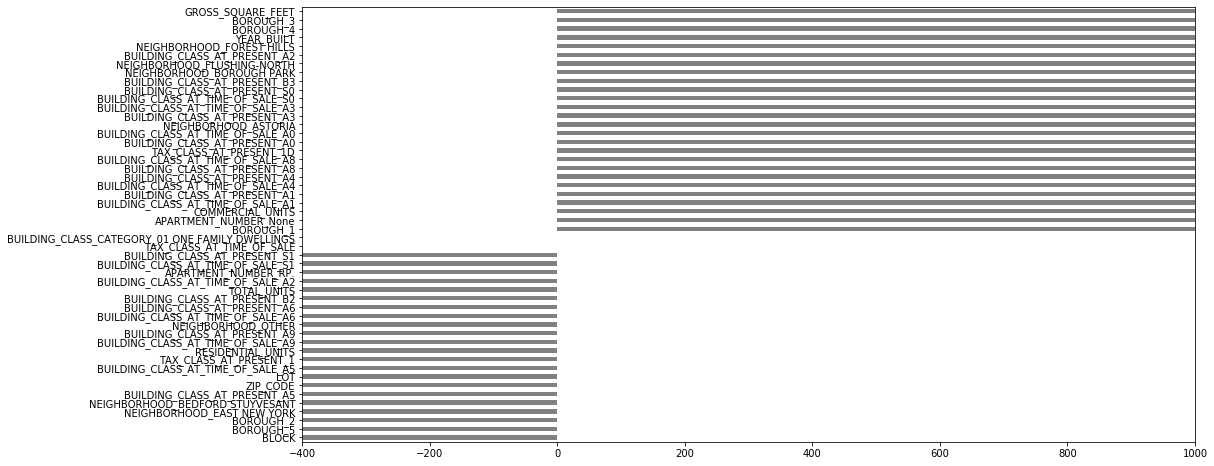

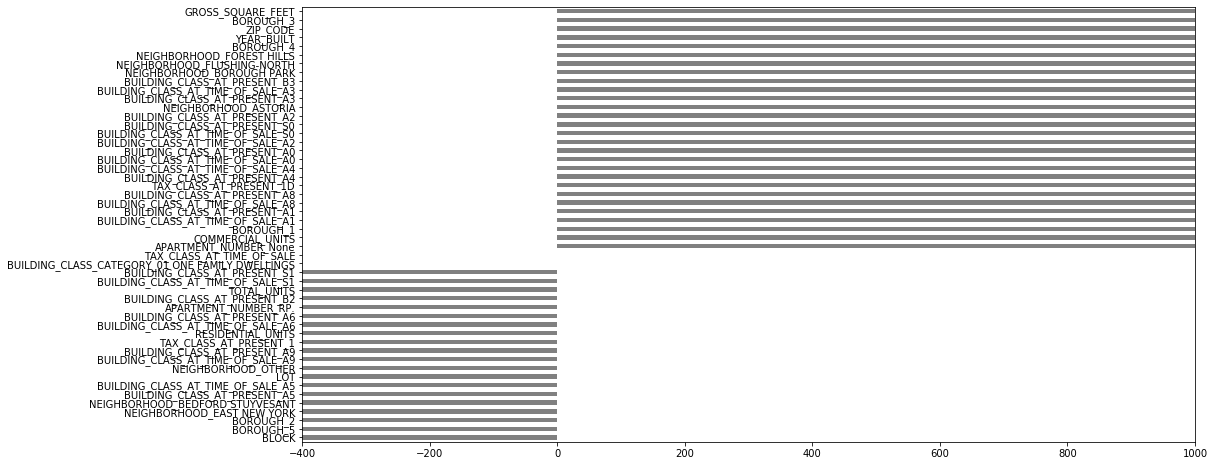

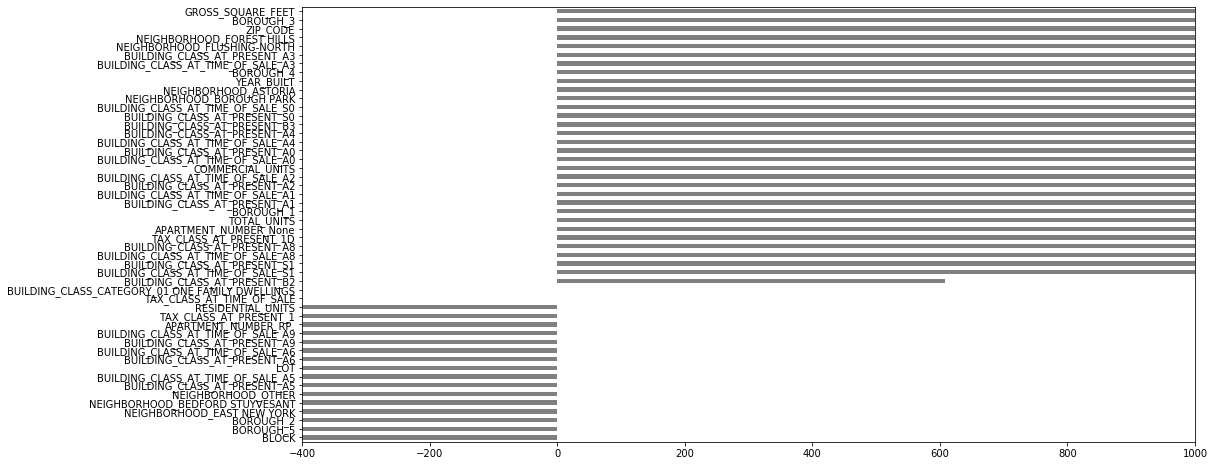

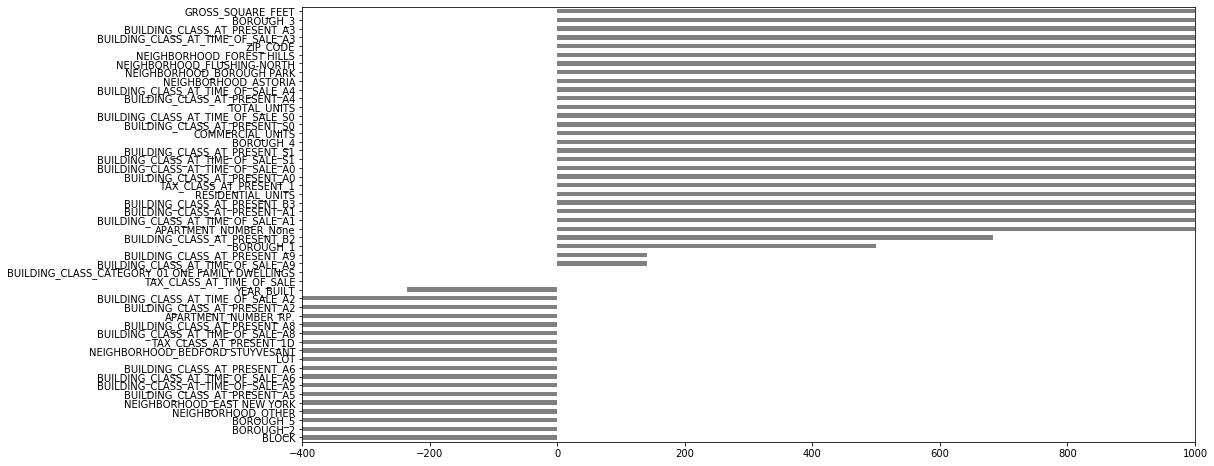

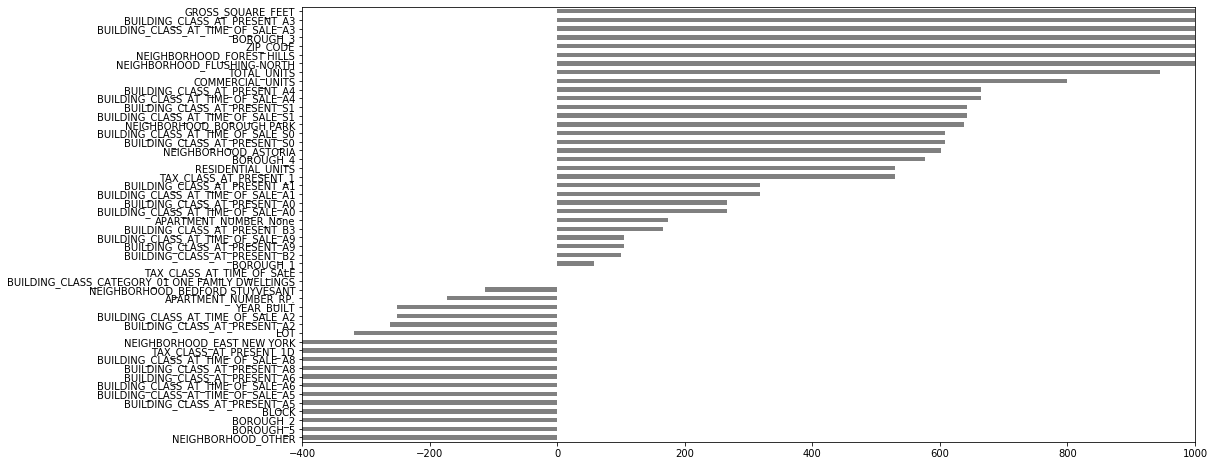

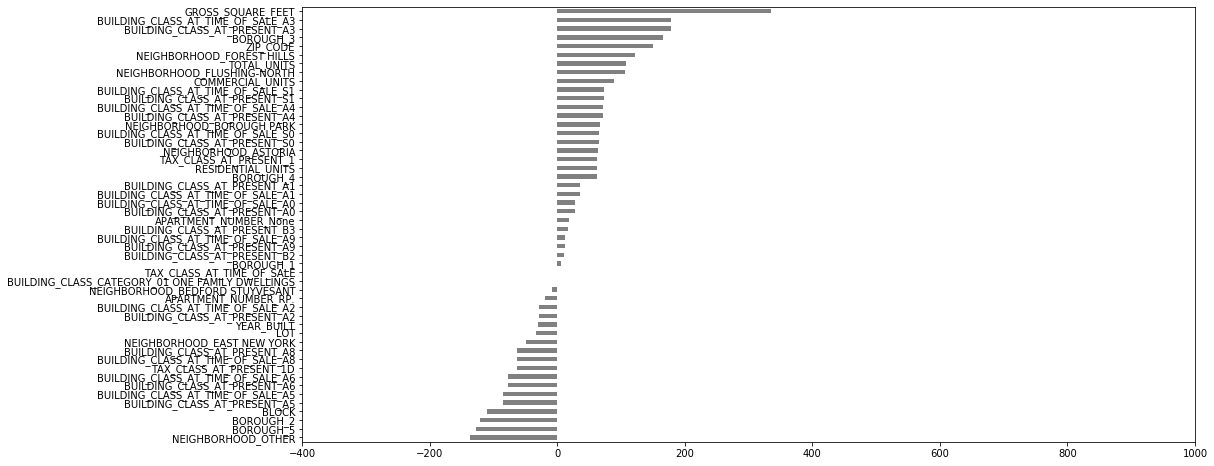

In [251]:
for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:
    
    # Scale data before doing Ridge Regression
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)

    # Get Train MAE
    y_pred = model.predict(X_train_scaled)
    mae = mean_absolute_error(y_train, y_pred)
    display(HTML(f'Train Mean Absolute Error: ${mae:,.0f}'))

    # Get Test MAE
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,1000)
    plt.show()

In [253]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.drop('SALE_PRICE', axis='columns')
y = df.SALE_PRICE

lin_reg = LinearRegression().fit(X, y)
mean_squared_error(y, lin_reg.predict(X))

ValueError: ignored

In [252]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)
lin_reg_split = LinearRegression().fit(X_train, y_train)
print(mean_squared_error(y, lin_reg_split.predict(X)))
print(mean_squared_error(y_test, lin_reg_split.predict(X_test)))

NameError: ignored

In [0]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

ridge_reg = Ridge().fit(X,y)
mean_squared_error(y, ridge_reg.predict(X))